# This notebook investigates the difference between enhanced and raw pitch and volume labels, across different models.
To reproduce this analysis, you will first need to run all using the script below (through SBATCH), then modify the `datasets.py` file, then run it again but while saving into a different folder. Then, make sure that you are loading the correct tasks in the correct elements of the NEUROPROBE_LITE_RESULTS array (will need to check the tasks and paths one by one, corresponding to the changes you made in the datasets.py), and after that the rest of the cells in this notebook should be run.

```bash
#!/bin/bash
#SBATCH --job-name=e_p_lite          # Name of the job
#SBATCH --ntasks=1             # 8 tasks total
#SBATCH --cpus-per-task=2    # Request 8 CPU cores per GPU
#SBATCH --mem=64G
#SBATCH -t 1:00:00         # total run time limit (HH:MM:SS) (increased to 24 hours)
#####SBATCH --gres=gpu:1
#####SBATCH --constraint=24GB
#SBATCH --exclude=dgx001,dgx002
#SBATCH --array=1-240  # 285 if doing mini btbench
#SBATCH --output data/logs/%A_%a.out # STDOUT
#SBATCH --error data/logs/%A_%a.err # STDERR
#SBATCH -p use-everything

nvidia-smi

export PYTHONUNBUFFERED=1
source .venv/bin/activate

# Use the BTBENCH_LITE_SUBJECT_TRIALS from btbench_config.py
declare -a subjects=(1 1 2 2 3 3 4 4 7 7 10 10)
declare -a trials=(1 2 0 4 0 1 0 1 0 1 0 1)

declare -a eval_names=(
    "volume"
    "pitch"
    "delta_volume"
    "delta_pitch"
)

declare -a preprocess_type=(
    'stft_abs' # just magnitude after FFT ("spectrogram")
)
declare -a preprocess_stft_nperseg=(
    128
    256
    400
    512
    768
    1024
)

declare -a preprocess_stft_poverlap=(
    0.0
    0.25
    0.50
    0.75
    0.875
    # 0.9375
    # 0.96875
)


declare -a splits_type=(
    "SS_SM"
)

declare -a classifier_type=(
    "linear"
)

# Calculate indices for this task
EVAL_IDX=$(( ($SLURM_ARRAY_TASK_ID-1) % ${#eval_names[@]} ))
PAIR_IDX=$(( ($SLURM_ARRAY_TASK_ID-1) / ${#eval_names[@]} % ${#subjects[@]} ))
PREPROCESS_TYPE_IDX=$(( ($SLURM_ARRAY_TASK_ID-1) / ${#eval_names[@]} / ${#subjects[@]} % ${#preprocess_type[@]} ))
PREPROCESS_STFT_POVERLAP_IDX=$(( ($SLURM_ARRAY_TASK_ID-1) / ${#eval_names[@]} / ${#subjects[@]} / ${#preprocess_type[@]} % ${#preprocess_stft_poverlap[@]} ))
SPLITS_TYPE_IDX=$(( ($SLURM_ARRAY_TASK_ID-1) / ${#eval_names[@]} / ${#subjects[@]} / ${#preprocess_type[@]} / ${#preprocess_stft_poverlap[@]} % ${#splits_type[@]} ))
CLASSIFIER_TYPE_IDX=$(( ($SLURM_ARRAY_TASK_ID-1) / ${#eval_names[@]} / ${#subjects[@]} / ${#preprocess_type[@]} / ${#preprocess_stft_poverlap[@]} / ${#splits_type[@]} % ${#classifier_type[@]} ))

# Get subject, trial and eval name for this task
EVAL_NAME=${eval_names[$EVAL_IDX]}
SUBJECT=${subjects[$PAIR_IDX]}
TRIAL=${trials[$PAIR_IDX]}
PREPROCESS_TYPE=${preprocess_type[$PREPROCESS_TYPE_IDX]}
PREPROCESS_STFT_POVERLAP=${preprocess_stft_poverlap[$PREPROCESS_STFT_POVERLAP_IDX]}
SPLITS_TYPE=${splits_type[$SPLITS_TYPE_IDX]}
CLASSIFIER_TYPE=${classifier_type[$CLASSIFIER_TYPE_IDX]}


for PREPROCESS_STFT_NPERSEG_IDX in "${!preprocess_stft_nperseg[@]}"; do
    PREPROCESS_STFT_NPERSEG=${preprocess_stft_nperseg[$PREPROCESS_STFT_NPERSEG_IDX]}

    save_dir="data/analyses/input_representation/modified_eval_results_lite_${SPLITS_TYPE}"

    echo "Running eval for eval $EVAL_NAME, subject $SUBJECT, trial $TRIAL, preprocess $PREPROCESS_TYPE, nperseg $PREPROCESS_STFT_NPERSEG, poverlap $PREPROCESS_STFT_POVERLAP, classifier $CLASSIFIER_TYPE"
    echo "Save dir: $save_dir"
    echo "Split type: $SPLITS_TYPE"

    # Add the -u flag to Python to force unbuffered output
    python -u eval_population.py \
        --eval_name $EVAL_NAME \
        --subject_id $SUBJECT \
        --trial_id $TRIAL \
        --preprocess.type $PREPROCESS_TYPE \
        --preprocess.stft.nperseg $PREPROCESS_STFT_NPERSEG \
        --preprocess.stft.poverlap $PREPROCESS_STFT_POVERLAP \
        --verbose \
        --save_dir $save_dir \
        --split_type $SPLITS_TYPE \
        --classifier_type $CLASSIFIER_TYPE \
        --only_1second
done
```

In [30]:
import torch
import neuroprobe.config as neuroprobe_config
from neuroprobe.braintreebank_subject import BrainTreebankSubject
from neuroprobe.datasets import BrainTreebankSubjectTrialBenchmarkDataset
import numpy as np
import json, os

def load_results(task_name, dirname, subject_trials):
    results_array = np.zeros((len(subject_trials)))
    for st_i, (subject_id, trial_id) in enumerate(subject_trials):
        results_path = os.path.join(dirname, f"population_btbank{subject_id}_{trial_id}_{task_name}.json")
        # print(results_path)
        with open(results_path, "r") as f:
            results = json.load(f)
            results = results["evaluation_results"][f"btbank{subject_id}_{trial_id}"]["population"]["one_second_after_onset"]
            results = np.mean([fold["test_roc_auc"] for fold in results["folds"]])
            results_array[st_i] = results
    return results_array

# noverlap: 0%, 25%, 50%, 75%, 87.5%, 93.75%
# nperseg: 400, 512, 256, 128
poverlap_options = [0.0, 0.25, 0.5, 0.75, 0.875]#, 0.9375]
nperseg_options = [128, 256, 400, 512, 768, 1024]

TASKS = ["old_pitch", "old_volume", "old_delta_pitch", "old_delta_volume", 
         "enhanced_pitch", "enhanced_volume", "enhanced_delta_pitch", "enhanced_delta_volume"]

NEUROPROBE_LITE_RESULTS = np.zeros((len(neuroprobe_config.NEUROPROBE_LITE_SUBJECT_TRIALS),
                                    len(TASKS),
                                    len(poverlap_options), len(nperseg_options)))

for poverlap_i, poverlap in enumerate(poverlap_options):
    for nperseg_i, nperseg in enumerate(nperseg_options):
        for task_i, task in enumerate(TASKS):
            enhanced = 'enhanced' in task
            task = task.replace('enhanced_', '').replace('old_', '')

            NEUROPROBE_LITE_RESULTS[:, task_i, poverlap_i, nperseg_i] = load_results(task, f"data/analyses/enhanced_pitch_volume/{'enhanced_' if enhanced else ''}eval_results_lite_SS_SM/linear_stft_abs_nperseg{nperseg}_poverlap{poverlap}", neuroprobe_config.NEUROPROBE_LITE_SUBJECT_TRIALS)

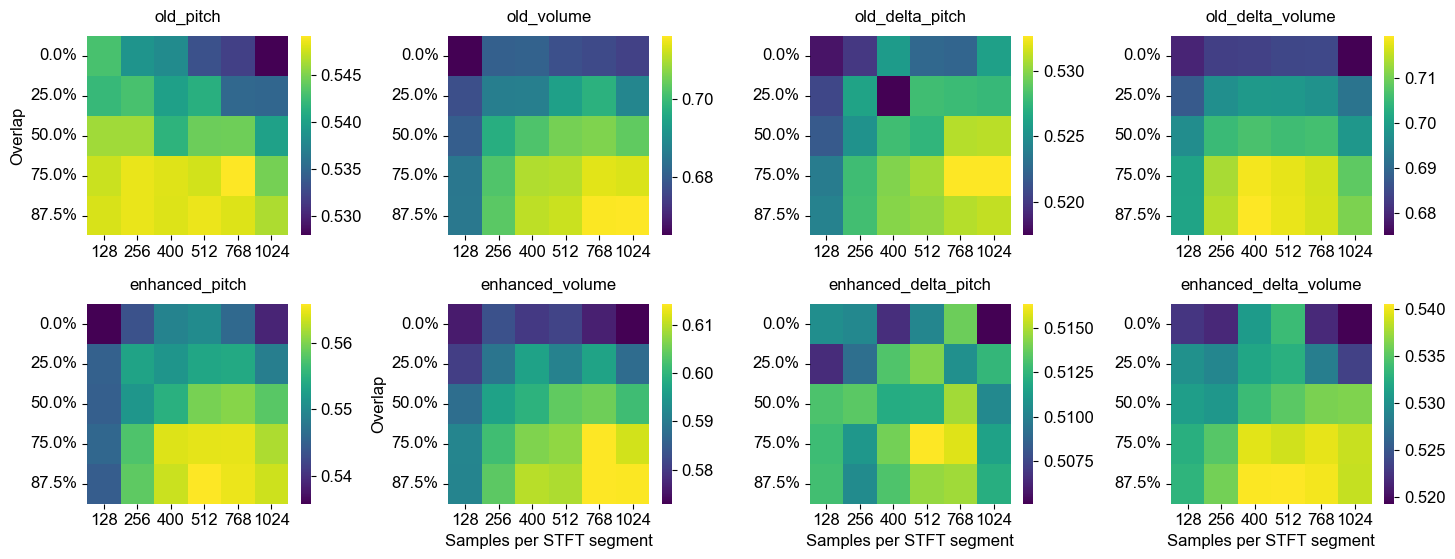

In [32]:
RESULTS_mean_st = NEUROPROBE_LITE_RESULTS.mean(axis=0) # shape: (n_tasks, n_poverlaps, n_npersegs)


import seaborn as sns
import math
import matplotlib.pyplot as plt
# Add Arial font
import matplotlib.font_manager as fm
font_path = 'assets/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})


# Create figure with 4x5 grid - reduced size
n_cols = 4
n_rows = math.ceil((len(TASKS))/n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(2.3*8/5*n_cols, 2.3*5/4*n_rows))

# Flatten axs for easier iteration
axs_flat = axs.flatten()

# Plot counter - start from 1 for remaining plots
plot_idx = 0

for task in TASKS:
    ax = axs_flat[plot_idx]
    t_i = TASKS.index(task)
    
    # Plot heatmap for each task
    sns.heatmap(RESULTS_mean_st[t_i],
                ax=ax,
                xticklabels=nperseg_options,
                yticklabels=[f"{p*100:.1f}%" for p in poverlap_options],
                cmap='viridis',
                # vmin=0.5,
                # vmax=0.7,
                cbar=True)
    
    ax.set_title(task, fontsize=12, pad=10, fontweight='bold')
    
    if plot_idx % 5 == 0:  # Right-most plots
        ax.set_ylabel('Overlap')
    else:
        ax.set_ylabel('')
        
    if plot_idx >= len(TASKS) - 3:  # Bottom plots
        ax.set_xlabel('Samples per STFT segment')
    else:
        ax.set_xlabel('')
    
    plot_idx += 1

# Remove empty subplots if any
for idx in range(plot_idx, len(axs_flat)):
    fig.delaxes(axs_flat[idx])

plt.tight_layout()
plt.show()
